In [1]:
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
import io

In [2]:
# Auxiliary functions


def load_vectors(fname):
    fin = io.open(fname, 'r', encoding='utf-8', newline='\n', errors='ignore')
    n, d = map(int, fin.readline().split())
    data = {}
    for i, line in enumerate(fin):
        if i == 100000: break
        tokens = line.rstrip().split(' ')
        data[tokens[0]] = np.asarray(list(map(float, tokens[1:])))
        data[tokens[0]] /=  np.linalg.norm(data[tokens[0]]) 
    return data


In [3]:
biased_dat = """he, her, his, she, him, man, women, men, woman, spokesman, wife, himself, son, mother, father, chairman,
daughter, husband, guy, girls, girl, boy, boys, brother, spokeswoman, female, sister, male, herself, brothers, dad,
actress, mom, sons, girlfriend, daughters, lady, boyfriend, sisters, mothers, king, businessman, grandmother,
grandfather, deer, ladies, uncle, males, congressman, grandson, bull, queen, businessmen, wives, widow,
nephew, bride, females, aunt, prostate cancer, lesbian, chairwoman, fathers, moms, maiden, granddaughter,
younger brother, lads, lion, gentleman, fraternity, bachelor, niece, bulls, husbands, prince, colt, salesman, hers,
dude, beard, filly, princess, lesbians, councilman, actresses, gentlemen, stepfather, monks, ex girlfriend, lad,
sperm, testosterone, nephews, maid, daddy, mare, fiance, fiancee, kings, dads, waitress, maternal, heroine,
nieces, girlfriends, sir, stud, mistress, lions, estranged wife, womb, grandma, maternity, estrogen, ex boyfriend,
widows, gelding, diva, teenage girls, nuns, czar, ovarian cancer, countrymen, teenage girl, penis, bloke, nun,
brides, housewife, spokesmen, suitors, menopause, monastery, motherhood, brethren, stepmother, prostate,
hostess, twin brother, schoolboy, brotherhood, fillies, stepson, congresswoman, uncles, witch, monk, viagra,
paternity, suitor, sorority, macho, businesswoman, eldest son, gal, statesman, schoolgirl, fathered, goddess,
hubby, stepdaughter, blokes, dudes, strongman, uterus, grandsons, studs, mama, godfather, hens, hen, mommy,
estranged husband, elder brother, boyhood, baritone, grandmothers, grandpa, boyfriends, feminism, countryman,
stallion, heiress, queens, witches, aunts, semen, fella, granddaughters, chap, widower, salesmen, convent,
vagina, beau, beards, handyman, twin sister, maids, gals, housewives, horsemen, obstetrics, fatherhood,
councilwoman, princes, matriarch, colts, ma, fraternities, pa, fellas, councilmen, dowry, barbershop, fraternal,
ballerina"""

biased_dat = biased_dat.replace(" ","").replace("\n","").strip("\r").split(",")

In [4]:
X = load_vectors("wiki-news-300d-1M.vec");

In [5]:
G = [X[k]  for k in biased_dat if k in X]
N = [X[k]  for k in set(X.keys()) - set(biased_dat) ]

In [6]:
G = np.array(G)
N = np.array(N)

In [8]:
P = get_pc_projection(G)

In [9]:
Nv = neutralise(N, P)

In [10]:
Nv /= np.linalg.norm(Nv, axis=1)[..., None]

[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.04371896 0.04371896 0.04371896 0.04371896 0.04371896 0.04371896
 0.04371896 0.04371896 0.04371896]
-0.050749412916890745 0.1314396123293881
[1. 1. 1. 1. 1. 1. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 1. 1.]


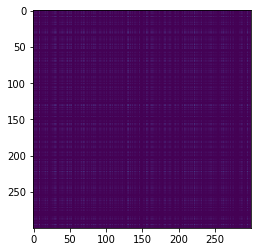

In [48]:
def get_pc_projection(X, k=1):
    n, d = X.shape
    X = X - X.mean(axis=0)
    C = (X.T.dot(X) / n)
    D, V = la.eigh(C)
    V = V[:, :k]
    return V.dot(V.T)

def create_nu(X, P):
    mu = X.mean(axis=0)
    nu = mu - P.dot(mu)
    return nu, P.dot(mu)

def equalize(E, P, N=None, debug=True):
    
    nu, mu_b = create_nu(E, P)
#     print(E[0,:] == E[1,:])
    if debug:
        print(np.linalg.norm(E, axis=1))
    
    E = E.dot(P) - 0 * mu_b
    
    if debug:
        print(np.linalg.norm(E, axis=1))
        plt.imshow(np.abs(P))
        print(np.min(P.ravel()), np.max(P.ravel()))

    E /= np.linalg.norm(E, axis=1)[..., None]
    
    v = np.linalg.norm(nu)
    fac = np.sqrt(1 - v**2)
    remb = nu +  fac * E
    
    if debug:
        print(np.linalg.norm(E,axis=1))
        print(np.linalg.norm(remb, axis=1))
    
    return remb, E

def neutralise(X, P):
    
    return X.dot((np.eye(P.shape[0]) - P))

# Make equaliser set out of : he, his, her, she, him, man, women, men, woman
E = G[0:9, :]

Eveq, E = equalize(E, P, Nv)

In [49]:
E = G[0:50, :]

In [50]:
Eveq

array([[ 0.02548287, -0.24334243,  0.04126261, ...,  0.0529063 ,
         0.05489104,  0.00746688],
       [ 0.02548287, -0.24334243,  0.04126261, ...,  0.0529063 ,
         0.05489104,  0.00746688],
       [ 0.02548287, -0.24334243,  0.04126261, ...,  0.0529063 ,
         0.05489104,  0.00746688],
       ...,
       [ 0.02548287, -0.24334243,  0.04126261, ...,  0.0529063 ,
         0.05489104,  0.00746688],
       [ 0.02548287, -0.24334243,  0.04126261, ...,  0.0529063 ,
         0.05489104,  0.00746688],
       [ 0.02548287, -0.24334243,  0.04126261, ...,  0.0529063 ,
         0.05489104,  0.00746688]])

In [51]:
Eveq.dot(Nv[-1,:])

array([0.25062409, 0.25062409, 0.25062409, 0.25062409, 0.25062409,
       0.25062409, 0.25062409, 0.25062409, 0.25062409])

In [74]:
np.linalg.norm(Eveq, axis=1)

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [35]:
r = P.dot(E[0,:].T)
n = (np.eye(P.shape[0]) - P).dot(r)

In [36]:
r.dot(n)

-9.012533258884773e-16

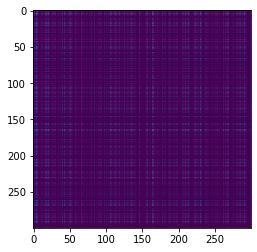

In [14]:
plt.imshow(np.abs(P))


In [144]:
(P == P.T).all()

True

In [128]:
np.diag(P).max(), np.diag(P).min(), (P - np.diag(np.diag(P))).max(), np.diag(np.abs(P)).max(), np.min(P), np.max(P), np.std(P)

(0.07888350546661169,
 0.0,
 0.06731093898807082,
 0.07888350546661169,
 -0.0548072525006003,
 0.07888350546661169,
 0.003333333329428014)

In [129]:
n, d = G.shape
Gc  = G - G.mean(axis=0)
C = (Gc.T.dot(Gc) / n)

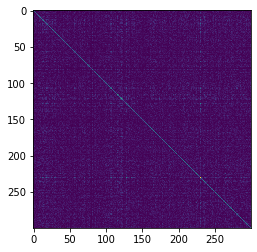

In [130]:
plt.imshow(np.abs(C))

In [131]:
np.linalg.matrix_rank(C)

201